In [484]:
import csv
from collections import defaultdict
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics.pairwise import cosine_similarity
import sys
#base_dir = os.environ['AWEB_DIR']
sys.path.append("../../")
import config

In [485]:
def convert_keys_to_int(d):
    new_dict = {}
    for k, v in d.items():
        new_key = int(k) if k.isdigit() else k
        if isinstance(v, dict):
            new_dict[new_key] = convert_keys_to_int(v)
        else:
            new_dict[new_key] = v
    return new_dict

In [486]:
result_dir = config.OUTPUT_DIR
embeddings_dir = config.EMBEDDING_DIR
data_dir = config.DATA_DIR
print(result_dir)
with open(data_dir+'attack_weak_range.json') as fp:
    attack_weak_range = json.load(fp)
with open(data_dir+"bron_attack_cwe.json") as fp:
    bron_attack_cwe=json.load(fp)
with open(data_dir+"bron_cwe_attack.json") as fp:
    bron_cwe_attack=json.load(fp)
with open(data_dir+"rand_hit_k_1000.json") as fp:
    rand_hit_k=json.load(fp)   
with open(data_dir+"rand_hit_k_avg_1000.json") as fp:
    rand_hit_k_avg=json.load(fp)

bron_attack_cwe = convert_keys_to_int(bron_attack_cwe)
bron_cwe_attack = convert_keys_to_int(bron_cwe_attack)
rand_hit_k = convert_keys_to_int(rand_hit_k)
rand_hit_k_avg = convert_keys_to_int(rand_hit_k_avg)
attack_size=attack_weak_range['attack'][1]
weakness_size=attack_weak_range['cwe'][1]-attack_size

/home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/


In [487]:
mx_w = 0
for a in bron_attack_cwe:
    mx_w = max(mx_w,len(bron_attack_cwe[a]))
print("Max # weak with an Attack:", mx_w)
mx_a = 0
for w in bron_cwe_attack:
    mx_a = max(mx_a,len(bron_cwe_attack[w]))
print("Max # attack with a weakness:", mx_a)

Max # weak with an Attack: 71
Max # attack with a weakness: 22


In [488]:
result_dir

'/home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/'

In [496]:
from collections import defaultdict
sample = 10
dual = "dual3"
loss_func = "triplet"
plot_dir = result_dir+"plots/sample_{}/{}/".format(sample,loss_func)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(plot_dir+"src/"):
    os.makedirs(plot_dir+"src/")
models = ["gpt2-xl", "gpt2-xl"]
gnn_models = ["GCN","GAT"]
features = ["text", "text_hop", "node2vec", "deepwalk"]
# gnn_models = ["GAN_embeddings","GCN_embeddings"]
graph_embeddings = {}
graph_embeddings["node2vec"]=np.load(embeddings_dir+"node2vec.npy")
graph_embeddings["deepwalk"]=np.load(embeddings_dir+"deepwalk.npy")
gnn_embeddings = defaultdict(list)
text_hop_embeddings = defaultdict(list)
text_hop_embeddings["bert"].append(np.load(embeddings_dir+"pt_bert/text_embeddings.npy"))
count=0
for model in models:
    text_emb_dir = embeddings_dir+model+"/"
    gcl_data_dir = result_dir+"gcl_data/"+model+"/"
    text_hop_embeddings["text"].append(np.load(text_emb_dir+"text_embeddings.npy"))
    text_hop_embeddings["hop_text"].append(np.load(text_emb_dir+"text_hop_embeddings.npy"))
    

    gnn_hop = []
    gnn_node2vec = []
    gnn_deepwalk = []
    gnn_text = []
    for j in range(len(gnn_models)):

        if(count==0):
            gnn_embeddings2=np.load(gcl_data_dir+"sample_{}/{}/{}/text_hop_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
            gnn_hop.append(gnn_embeddings2)
            gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/node2vec_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
            gnn_node2vec.append(gnn_embeddings3)
            gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/deepwalk_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
            gnn_deepwalk.append(gnn_embeddings3)
            gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/text_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
            gnn_text.append(gnn_embeddings3)
        else:
            gnn_embeddings2=np.load(gcl_data_dir+"sample_{}/{}/{}/text_hop_{}_gm_1.0.npy".format(sample,gnn_models[j],loss_func,dual))
            gnn_hop.append(gnn_embeddings2)
            gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/text_node2vec_{}_gm_1.0.npy".format(sample,gnn_models[j],loss_func,dual))
            gnn_node2vec.append(gnn_embeddings3)
            gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/text_deepwalk_{}_gm_1.0.npy".format(sample,gnn_models[j],loss_func,dual))
            gnn_deepwalk.append(gnn_embeddings3)

        
    
        # gnn_embeddings2.append(np.load(dir_name+"{}/sample_{}/hop_gm_1.0.npy".format(gnn_models[j],sample)))
        # gnn_emb_matrix2.append(cosine_similarity(gnn_embeddings2[-1]))
        # gnn_embeddings2.append(np.load(dir_name+"{}/sample_{}/node2vec_gm_1.0.npy".format(gnn_models[j],sample)))
        # gnn_emb_matrix2.append(cosine_similarity(gnn_embeddings2[-1]))
    gnn_embeddings["hop_text"].append(gnn_hop)
    gnn_embeddings["node2vec"].append(gnn_node2vec)
    gnn_embeddings["deepwalk"].append(gnn_deepwalk)
    if(count==0):
        gnn_embeddings["text"].append(gnn_text)
    count+=1


In [497]:
from scipy.stats import spearmanr
def calc_intersect(base, cmp_emb, ctype, isAverage, isSrc):
    # Loop over each k from 10 to 1136
    average_hit_at_k = {}
    avg_src_at_k = {}
    if(ctype=="attack_graph"):
        size = attack_size
        cmp_matrix = cosine_similarity(cmp_emb[:attack_size],cmp_emb[:attack_size])
        base_matrix = base
    elif(ctype=="weak_graph"):
        size = weakness_size
        cmp_matrix =  cosine_similarity(cmp_emb[attack_size:],cmp_emb[attack_size:])
        base_matrix = base
    if(ctype=="attack_text"):
        size = attack_size
        cmp_matrix = cosine_similarity(cmp_emb[:attack_size],cmp_emb[:attack_size])
        base_matrix = cosine_similarity(base[:attack_size],base[:attack_size])
    elif(ctype=="weak_text"):
        size = weakness_size
        cmp_matrix =  cosine_similarity(cmp_emb[attack_size:],cmp_emb[attack_size:])
        base_matrix = cosine_similarity(base[attack_size:],base[attack_size:])
    elif(ctype=="text"):
        size = attack_size+weakness_size
        cmp_matrix =  cosine_similarity(cmp_emb)
        base_matrix = cosine_similarity(base)
    for k in range(5, 30,5):
        hit_at_k = []
        src_at_k = []
        for i in range(size):
            # Get the indices of the top k values in the row for both matrices

            top_base = np.argsort(base_matrix[i])[-k:]
            top_k = np.argsort(cmp_matrix[i])[-k:]
            
            # Calculate the hit@k (number of common indices in top k)
            #hit_count = len(set(top_bron) & set(top_k))
            if(isSrc==1):
                spearman_corr, _ = spearmanr(top_base, top_k)
                src_at_k.append(spearman_corr)
            else:
                if(isAverage):
                    hit_count = len(set(top_base) & set(top_k))/k
                    
                else:
                    hit_count = len(set(top_base) & set(top_k))
                hit_at_k.append(hit_count)
            # Append the result to the list
            
            
        # Calculate the average hit@k for the current k
        # print(hit_at_k)
        if(isSrc==1):
            avg_src_at_k[k] = np.mean(src_at_k)
        else:
            average_hit_at_k[k] = np.mean(hit_at_k)
    if(isSrc==1):    
        return avg_src_at_k
    else:
        return average_hit_at_k

In [498]:
def list_subtract(list1,list2):
    return [x-y for x,y in zip(list2,list1)]

In [499]:
list_subtract([1,2,3,4],[2,3,9,5])

[1, 1, 6, 1]

In [507]:

def plot_hit_k_graph_gnn(base, ctype, isAverage, isSrc):
    isGraph = True
    dual = "s_d"
    models = ["single encoder","dual encoder"]
    if(ctype!="text" and ctype.split("_")[1]=="text"):
        isGraph = False
    # Initialize a dictionary to store average hit@k for each k
    markers = ['o', 's', '+', 'v', '<', '>']
    colors = list(mcolors.TABLEAU_COLORS)
    colors.pop(3)
    plt.figure(figsize=(3, 3))
    # Loop over all the models
    #models = ["pretrained_SecBert", "SecBert", "pretrained_SecureBert",  "SecureBert", "pretrained_Gpt2","Gpt2"]
    #models = ["Gpt2"]
    ks = list(range(5, 30,5))
    if(ctype.split("_")[0]=="attack"):
        size = attack_size
    else:
        size = weakness_size
    hit_differ = {}
    hits2 = list(calc_intersect(base, graph_embeddings["node2vec"], ctype, isAverage, isSrc).values())
    hits3 = list(calc_intersect(base, graph_embeddings["deepwalk"], ctype, isAverage, isSrc).values())
    if(isGraph):
        base_hit = hits3

    else:
        base_hit = list(calc_intersect(base, text_hop_embeddings["text"][0], ctype, isAverage, isSrc).values())
    hit_differ["node2vec"] = list_subtract(hits2,base_hit)
    hit_differ["deepwalk"] = list_subtract(hits3,base_hit)
    
    plt.plot(ks, hits2, label="node2vec", marker='*', color = 'tab:olive')
    plt.plot(ks, hits3, label="deeplwalk", marker='p', color = 'tab:cyan')
    all_hits = []
    for i in range(0,len(models),1):
        # Define the cosine similarity matrices
        model = models[i]

        hits7 = list(calc_intersect(base, text_hop_embeddings["text"][i], ctype, isAverage, isSrc).values())
        hits8 = list(calc_intersect(base, text_hop_embeddings["hop_text"][i], ctype, isAverage, isSrc).values())
        name = model+"_"
        hit_differ[name+"text"]=list_subtract(hits7,base_hit)
        hit_differ[name+"hop_text"]=list_subtract(hits8,base_hit)
        if(i==0):
            cl1 = "tab:green"
            plt.plot(ks, hits7, label=" Text emb", marker='.', color = cl1)
        else:
            cl1 = "tab:purple"
        
        # plt.plot(ks, hits8, label=models[i]+" Hop emb", marker='v', color = cl1)
        
        for j in range(len(gnn_models)):
            name = model+"_"+gnn_models[j]+"_"
            hits4 = list(calc_intersect(base, gnn_embeddings["hop_text"][i][j], ctype, isAverage, isSrc).values())
            hits5 = list(calc_intersect(base, gnn_embeddings["node2vec"][i][j], ctype, isAverage, isSrc).values())            # if(j==2 or j==5):
            hits6 = list(calc_intersect(base, gnn_embeddings["deepwalk"][i][j], ctype, isAverage, isSrc).values()) 
            hit_differ[name+"hop_text"]=list_subtract(hits4,base_hit)
            hit_differ[name+"node2vec"]=list_subtract(hits5,base_hit)
            hit_differ[name+"deepwalk"]=list_subtract(hits6,base_hit)
            if(i==0):
                hits9 = list(calc_intersect(base, gnn_embeddings["text"][i][j], ctype, isAverage, isSrc).values()) 
                hit_differ[name+"text"]=list_subtract(hits9,base_hit)
            # plt.plot(ks, hits4, label=models[i]+" "+gnn_models[j] +" hop", marker="s", color = colors[j+i*5])
            plt.plot(ks, hits5, label=models[i]+" "+gnn_models[j]+ " node2vec", marker="*", color = colors[j+i*5])
            plt.plot(ks, hits6, label=models[i]+" "+gnn_models[j]+ " deepwalk", marker="p", color = colors[j+i*5])
            # if(dual==""):
            # if(i==0):
            #     plt.plot(ks, hits9, label=models[i]+" "+gnn_models[j]+ " text", marker="o", color = colors[j+i*5])
        

        


    plt.xlabel('K')
    plt.ylabel('Average Precision@k')
    plt.xticks(ks)
    plt.grid(True)
    plt.legend(fontsize="12",bbox_to_anchor=(1.1, 1.05))
    #plt.title('GNN Semi Supervised - Text - Hop Embeddings')
    
    if(isSrc==1):
        evl_method = "SRC"
        plot_dir2 = plot_dir+"src/"
    else:
        evl_method = "hit@k"
        plot_dir2 = plot_dir
    if(ctype.split("_")[0]=="attack"):
        if(isAverage):
            #plt.title('GNN-{} Avg Hit@k Attack - {}'.format(dual,ctype))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "e1_{}_hit@k_gnn_{}_sample_{}.png".format(ctype,dual,sample)
        else:
            #plt.title('GNN-{} Hit@k Attack - {}'.format(dual,ctype))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "e1_{}_hit@k_gnn_{}_sample_{}.png".format(ctype,dual,sample)
    elif(ctype.split("_")[0]=="weak"):
        if(isAverage):
            #plt.title('GNN-{} Avg Hit@k CWE to {}'.format(dual,ctype))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "e1_{}_hit@k_gnn_{}_sample_{}.png".format(ctype,dual,sample)
        else:
            #plt.title('GNN-{} Hit@k CWE to {}'.format(dual,ctype))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "e1_{}_hit@k_gnn_{}_sample_{}.png".format(ctype,dual,sample)
    elif(ctype=="text"):
        if(isAverage):
            #plt.title('GNN-{} Avg Hit@k Bert Text'.format(dual))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "e1_{}_hit@k_gnn_{}_sample_{}.png".format(ctype,dual,sample)
        else:
            #plt.title('GNN-{} Hit@k Bert Text'.format(dual))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "e1_{}_hit@k_gnn_{}_sample_{}.png".format(ctype,dual,sample)
    plt.savefig(plot_dir2+title, dpi=300, bbox_inches='tight')
    print("save file name: ", plot_dir2+title)
    plt.show()
    return hit_differ

In [508]:
len(gnn_embeddings["text"])

1

save file name:  /home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/plots/sample_10/triplet/e1_attack_text_hit@k_gnn_s_d_sample_10.png


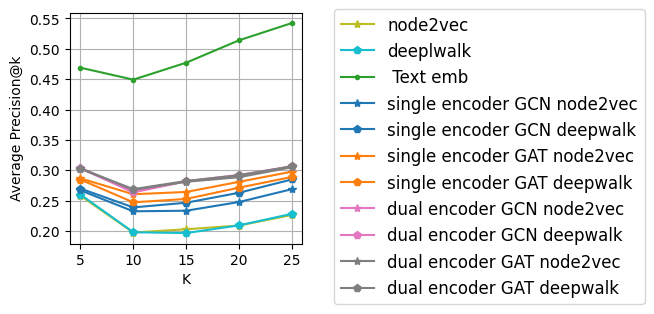

In [509]:
attack_text_hit_differ = plot_hit_k_graph_gnn(text_hop_embeddings["bert"][0], "attack_text", True,0)

save file name:  /home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/plots/sample_10/triplet/e1_weak_text_hit@k_gnn_s_d_sample_10.png


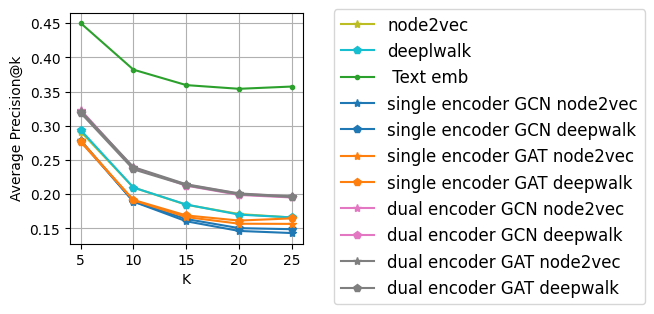

In [510]:
weak_text_hit_differ = plot_hit_k_graph_gnn(text_hop_embeddings["bert"][0], "weak_text", True,0)

save file name:  /home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/plots/sample_10/triplet/e1_text_hit@k_gnn_s_d_sample_10.png


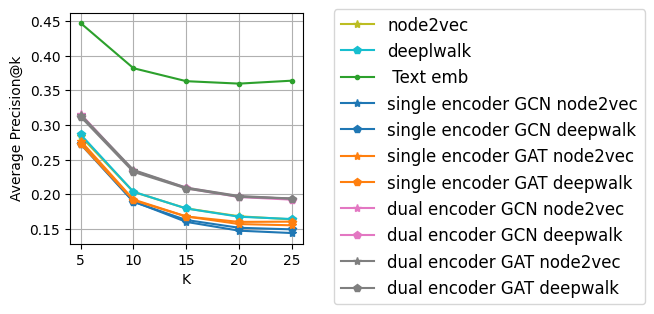

In [511]:
x=plot_hit_k_graph_gnn(text_hop_embeddings["bert"][0], "text", True, 0)

In [512]:
weakness_hop_sim_matrix = np.load(data_dir+'weakness_hop_sim_matrix.npy')
attack_hop_sim_matrix = np.load(data_dir+'attack_hop_sim_matrix.npy')

save file name:  /home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/plots/sample_10/triplet/e1_attack_graph_hit@k_gnn_s_d_sample_10.png


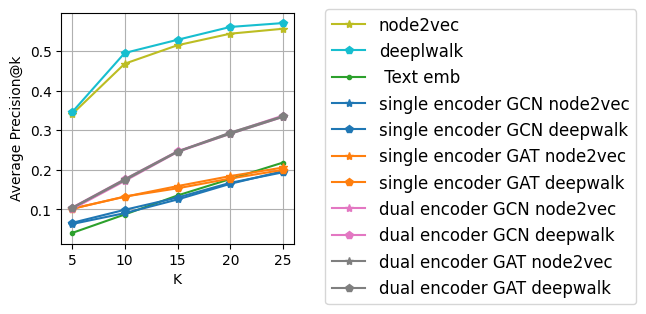

In [513]:
attack_graph_hit_differ = plot_hit_k_graph_gnn(attack_hop_sim_matrix, "attack_graph", True, 0)

save file name:  /home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/plots/sample_10/triplet/e1_weak_graph_hit@k_gnn_s_d_sample_10.png


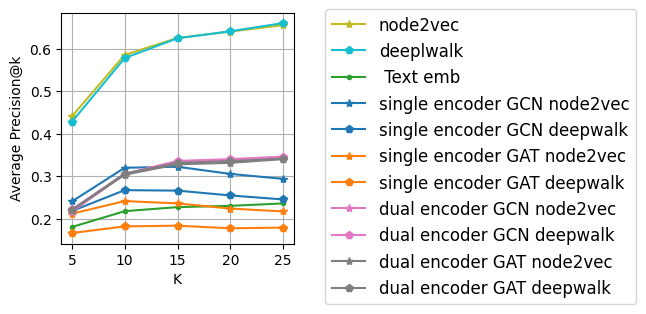

In [514]:
weak_graph_hit_differ = plot_hit_k_graph_gnn(weakness_hop_sim_matrix, "weak_graph", True, 0)

In [515]:
hit_differ={"attack_text":attack_text_hit_differ,
           "weak_text":weak_text_hit_differ,
           "attack_graph":attack_graph_hit_differ,
           "weak_graph":weak_graph_hit_differ}

In [516]:
with open(plot_dir+"hit_difference_{}.json".format(dual),'w') as f:
    json.dump(hit_differ,f)

In [160]:
# plot_hit_k_graph_gnn(text_hop_embeddings["bert"][0], "attack_text", True,1)

In [140]:
# plot_hit_k_graph_gnn(text_hop_embeddings["bert"][0], "weak_text", True,1)

In [120]:
# plot_hit_k_graph_gnn(text_hop_embeddings["bert"][0], "text", True, 1)

In [121]:
# plot_hit_k_graph_gnn(attack_hop_sim_matrix, "attack_graph", True, 1)

In [122]:
# plot_hit_k_graph_gnn(weakness_hop_sim_matrix, "weak_graph", True, 1)